# **NLP / OCR model for regulatory complaince model.**

## **Objective :**
* This project shall provide a trained model which could detect transactions that aren't according to the compliance rules (Basel Committee and Enforcement Guide is used in here for now) which shall be used in `creating a dashboard` and also a `chatbot` powered by serverless inference.

## **Data :**
* Basel Committee pdf downloaded from https://www.bis.org/bcbs/publ/d383.pdf
* Enforcement Guide pdf downloaded from https://www.handbook.fca.org.uk/handbook/EG.pdf 
* Credit card fraud detection dataset from kaggle https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
* Synthetic financial dataset from kaggle https://www.kaggle.com/datasets/ealaxi/paysim1


### **Importing required libraries**
>The required dependencies are listed in `requirements.txt`. You could install it in your python environment. (venv)


In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib
import PyPDF2
import re
import spacy
from spacy.matcher import Matcher
from nltk.tokenize import sent_tokenize
from transformers import pipeline
import torch
import tensorflow as tf

c:\Users\LEGION\Desktop\Vultr GFG project\Regulatory compliance system\Regulatory-compliance-system\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load datasets
credit_data = pd.read_csv('data/creditcard.csv')
synthetic_data = pd.read_csv('data/synthetic_financial_data.csv')

In [3]:
# Display all of the columns and rows of a Pandas DataFrame.

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [4]:
credit_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
synthetic_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
# Making a list of numerical features of credit card data.
credit_num_features = [columns for columns in credit_data.columns if credit_data[columns].dtypes == 'int64' or credit_data[columns].dtypes == 'float64']
# Making a list of categorical features of credi card data.
credit_cat_features = [columns for columns in credit_data.columns if credit_data[columns].dtypes == 'object']

In [ ]:
# Making a list of numerical features of synthetic data.
synthetic_num_features = [columns for columns in synthetic_data.columns if synthetic_data[columns].dtypes == 'int64' or synthetic_data[columns].dtypes == 'float64']
# Making a list of categorical features of synthetic data.
synthetic_cat_features = [columns for columns in synthetic_data.columns if synthetic_data[columns].dtypes == 'object']

In [8]:
credit_data.shape

(284807, 31)

In [9]:
synthetic_data.shape

(6362620, 11)

### **Merging the datasets.**

In [10]:
# Renaming the columns for consistency.
credit_data.rename(columns={'Time' : 'step', 'Amount' : 'amount', 'Class' : 'isFraud'}, inplace = True)

In [11]:
synthetic_data[synthetic_data['isFlaggedFraud'] != 0]['amount'].median()

np.float64(4234245.095)

In [12]:
# Adding missing columns with placeholder values
credit_data['nameOrig'] = 'Unknown'
credit_data['oldbalanceOrg'] = 0
credit_data['newbalanceOrig'] = 0
credit_data['nameDest'] = 'Unknown'
credit_data['oldbalanceDest'] = 0
credit_data['newbalanceDest'] = 0

# Create `isFlaggedFraud` column with 0 as default
credit_data['isFlaggedFraud'] = 0

# Set a custom condition for flagging transactions as fraud (amount threshold)
# Here, we assume transactions above a certain amount are flagged
# We are considering that 
credit_data.loc[credit_data['amount'] > 10000, 'isFlaggedFraud'] = 1

**Here we will be using some common thresholds to mimic the real world scenario in the column `type` which is added in the credit card data to get it aligned with synthetic data.** 

In [13]:
# Start with default type
credit_data['type'] = 'PAYMENT'  # Set PAYMENT as the most common default type

# Apply thresholds for realistic transaction types
credit_data.loc[credit_data['amount'] < 100, 'type'] = 'DEPOSIT'       # Micro-transactions
credit_data.loc[(credit_data['amount'] >= 100) & (credit_data['amount'] < 500), 'type'] = 'PAYMENT'  # Consumer payments
credit_data.loc[(credit_data['amount'] >= 500) & (credit_data['amount'] < 5000), 'type'] = 'CASH_OUT'  # Cash withdrawals
credit_data.loc[credit_data['amount'] >= 5000, 'type'] = 'TRANSFER'    # Large transfers


**Generating PCA components that reflect actual patterns within the synthetic dataset, producing more meaningful values in `V1` to `V8`.**
Since our synthetic dataset has only 8 numerical features.

**The next 20 features (from 9 to 28) shall be generated by analyze the distribution (mean, standard deviation) of each V1 to V28 component in the credit card dataset.**

In [14]:
# V1 to V8
# Standardizing the selected features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(synthetic_data[synthetic_num_features])

# Applying PCA to produce 8 components
pca = PCA(n_components=8)
pca_components = pca.fit_transform(scaled_features)

# Adding PCA components back into the synthetic data as V1 to V8
for i in range(8):
    synthetic_data[f'V{i+1}'] = pca_components[:, i]

# V9 to V28
# Calculate the mean and std for each V column in credit card data
v_columns = [f'V{i}' for i in range(9, 29)]
v_stats = credit_data[v_columns].agg(['mean', 'std'])

# Generate V1 to V28 in synthetic data based on these stats
for v in v_columns:
    mean = v_stats.loc['mean', v]
    std_dev = v_stats.loc['std', v]
    synthetic_data[v] = np.random.normal(loc=mean, scale=std_dev, size=len(synthetic_data))

In [15]:
# Checking whether we have got same number of columns in both of them.
print('Columns are aligned' if len(credit_data.columns) == len(synthetic_data.columns) else 'Columns are not aligned')

Columns are aligned


In [16]:
synthetic_data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,-0.670313,-0.060761,-0.643078,-1.406287,-0.671536,-0.104773,0.006774,-0.005467,-0.132993,2.122614,0.004269,-1.969756,-1.878248,-0.623679,-1.379822,-0.024419,1.065234,0.633258,-0.154486,-1.723097,0.138774,-0.427415,0.004660,-0.661720,-0.171061,0.781714,0.389473,0.400586
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,-0.700352,-0.124134,-0.646599,-1.407125,-0.668683,-0.119190,0.007704,-0.003070,0.466774,1.685808,-0.132913,1.584742,0.165662,-0.265938,-0.222900,-0.145721,0.722730,0.371154,-0.645070,1.600922,-0.930190,-0.068244,-0.397065,0.374992,-0.479286,0.496010,-0.185208,0.255576
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,-0.112330,-0.491883,19.781098,-1.518864,-17.824060,-8.085217,0.148910,0.362623,-1.075068,1.993468,0.377306,-2.152705,-0.400194,0.804860,0.535346,-0.527386,-0.407436,-0.716120,0.441539,-0.300903,0.176428,0.238378,-1.296027,-0.162322,0.600480,0.349148,-1.003710,-0.342967
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,-0.108616,-0.493141,19.780491,-1.518932,-17.823607,-8.087501,0.144719,0.362320,2.253092,-0.015063,1.133243,-0.946952,-2.770274,-0.505198,0.054582,0.944604,-0.823060,0.845154,-0.895469,-0.860207,0.412869,0.711235,-0.932434,-0.226189,0.613624,0.782721,0.093276,0.096420
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,-0.691715,-0.120087,-0.643614,-1.407425,-0.671659,-0.104807,0.005738,-0.005592,0.081630,-2.359967,-1.203567,0.375182,0.649968,-0.830289,0.328181,-0.154941,-0.870885,-0.503077,0.461953,0.025661,-1.311302,-1.429761,0.490829,-0.104722,0.397147,0.257984,0.219986,0.108967


**Concatenating and shuffling the combined dataset.**

In [17]:
# Concatenating datasets
combined_data = pd.concat([credit_data, synthetic_data], ignore_index=True)

# Shuffling the data
data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
data.shape

(6647427, 39)

In [35]:
data.head()

,step,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,isFraud,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,type
0,11.0,-0.636414,-0.118037,-0.597735,-1.351517,-0.663164,-0.001489,-0.012015,0.016236,-0.184191,-1.719229,-1.588395,-0.037241,-0.412919,-2.281289,0.046480,-1.482891,-0.742197,-0.532935,-1.088831,0.583264,0.803572,-0.146718,0.691678,-0.175862,0.196461,-0.602012,-0.094314,0.238812,82149.56,0,C1748606530,51492.00,133641.56,C538246534,3681.48,0.00,0,CASH_IN
1,209.0,-0.622630,-0.078446,-0.117049,-0.188273,-0.060687,-0.083896,0.012740,-0.003933,-0.800181,2.011341,0.004997,0.527588,-0.208880,-0.367278,0.198161,-0.007003,0.005098,-0.379655,0.136786,0.642884,1.293716,0.168931,1.132701,0.132311,-0.114744,-0.224968,-0.105769,0.196618,2906.19,0,C29790915,221719.00,218812.81,M422568607,0.00,0.00,0,PAYMENT
2,178.0,-0.590914,-0.202171,-0.171547,-0.376033,-0.178126,0.039663,0.009182,-0.007276,-0.038846,-0.742687,0.665026,0.924495,0.034098,1.040870,0.218029,0.805204,-0.288278,-0.156389,-0.272878,-0.603018,0.293781,-0.483382,-0.058860,0.692587,-0.291077,-0.004671,0.262709,0.164153,98404.14,0,C1217635081,20457.00,0.00,C1117731291,0.00,98404.14,0,CASH_OUT
3,359.0,0.360487,2.281061,0.311287,0.731493,0.356131,0.070796,0.031695,-0.011446,1.155161,-0.831183,-0.768668,-0.207394,0.448015,-1.182172,0.408841,-0.865575,1.009723,-0.675566,-0.518133,0.108537,0.203128,0.660452,1.137936,-0.692939,-0.625743,0.562953,0.028163,-0.558026,26021.32,0,C1809903413,5505848.86,5531870.18,C1321612374,63446.80,37425.49,0,CASH_IN
4,7.0,-0.690074,-0.123918,-0.627870,-1.372431,-0.654654,-0.101275,0.005436,-0.006071,1.000763,1.139813,0.045666,-1.088506,-0.271937,-0.228143,1.020210,-0.156448,-1.197458,0.029189,-1.548256,0.089941,-0.575743,-0.323324,0.017972,-0.173067,0.272267,-0.513166,0.093378,-0.136254,13594.95,0,C1531435701,38195.86,24600.91,M1137843904,0.00,0.00,0,PAYMENT


In [25]:
data_cat_features = [columns for columns in data.columns if data[columns].dtypes == 'object']
data_cat_features

['nameOrig', 'nameDest', 'type']

## **Preprocessing**

In [31]:
# Define numerical and categorical columns
numeric_columns = [columns for columns in data.columns if data[columns].dtypes == 'int64' or data[columns].dtypes == 'float64']  # Standardized columns
v_features = [f'V{i}' for i in range(1, 29)]  # Here only V1 to V4 are used for simplicity
all_numeric_features = numeric_columns + v_features
categorical_features = ['type']

# Create ColumnTransformer with StandardScaler and OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),             # Standardize numeric features
        ('cat', OneHotEncoder(drop='first'), categorical_features)   # One-hot encode 'type'
    ]
)

# Apply transformation
preprocessed_data = preprocessor.fit_transform(combined_data)

# Get processed column names
numeric_column_names = numeric_columns
onehot_column_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_column_names = numeric_column_names + list(onehot_column_names)

# Convert transformed data back to DataFrame with column names
preprocessed_df = pd.DataFrame(preprocessed_data, columns=all_column_names)

# Add target columns back
preprocessed_df[['isFraud', 'isFlaggedFraud']] = combined_data[['isFraud', 'isFlaggedFraud']].reset_index(drop=True)

In [32]:
preprocessed_df.head()

,step,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,isFraud,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_DEPOSIT,type_PAYMENT,type_TRANSFER
0,-0.199529,-0.893008,-0.051491,2.396911,1.352045,-0.338883,0.516741,0.890430,0.396178,0.331409,0.083965,-0.540482,-0.618226,-0.996785,-0.324414,1.604052,-0.536814,0.245035,0.030604,0.495724,0.325553,-0.024761,0.382771,-0.176941,0.110791,0.246263,-0.392110,0.330254,-0.063512,-0.290606,0,-0.281961,-0.285586,-0.316092,-0.325417,0,0.0,0.0,0.0,1.0,0.0
1,-0.199529,0.782712,0.188295,0.157328,0.439664,0.060117,-0.092042,-0.292859,0.341602,-0.232056,-0.152828,1.580083,1.065175,0.490735,-0.149785,0.694257,0.529203,-0.134948,-0.218831,-0.179367,-0.090172,-0.307196,-0.880688,0.162150,-0.561156,0.320364,0.261146,-0.022853,0.044913,-0.290854,0,-0.281961,-0.285586,-0.316092,-0.325417,0,0.0,0.0,1.0,0.0,0.0
2,-0.199483,-0.892054,-0.948132,1.675727,0.372584,-0.504034,2.012147,2.941339,0.994182,-1.377918,0.191305,0.611839,0.065807,0.720018,-0.172916,2.563094,-3.297569,1.306901,-0.144887,-2.777773,0.680407,0.337771,1.063560,1.456189,-1.138384,-0.628772,-0.288383,-0.137721,-0.180791,-0.290219,0,-0.281961,-0.285586,-0.316092,-0.325417,0,0.0,0.0,0.0,1.0,0.0
3,-0.199483,-0.634567,-0.131043,1.694423,-0.846936,-0.010326,1.393811,0.883036,1.515044,-1.261778,-0.049921,-0.221943,0.177976,0.509486,-0.300164,-0.690157,-1.209119,-0.805135,2.344233,-1.513937,-0.270414,-0.147273,0.007027,-0.304799,-1.941689,1.241483,-0.460158,0.154779,0.186542,-0.290650,0,-0.281961,-0.285586,-0.316092,-0.325417,0,0.0,0.0,0.0,1.0,0.0
4,-0.199436,-0.760631,0.620977,1.463577,0.395398,-0.407870,0.107197,2.203570,-1.085930,0.744492,0.692353,-0.806241,0.538021,1.351564,-1.167843,0.191141,-0.515191,-0.278840,-0.045705,0.986277,0.529372,-0.012678,1.100228,-0.220151,0.233591,-0.395460,1.041706,0.542958,0.652325,-0.290740,0,-0.281961,-0.285586,-0.316092,-0.325417,0,0.0,0.0,1.0,0.0,0.0


In [33]:
preprocessed_df.shape

(6647427, 41)

In [38]:
preprocessed_df.isna().sum()

step              0
V1                0
V2                0
V3                0
V4                0
V5                0
V6                0
V7                0
V8                0
V9                0
V10               0
V11               0
V12               0
V13               0
V14               0
V15               0
V16               0
V17               0
V18               0
V19               0
V20               0
V21               0
V22               0
V23               0
V24               0
V25               0
V26               0
V27               0
V28               0
amount            0
isFraud           0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFlaggedFraud    0
type_CASH_OUT     0
type_DEBIT        0
type_DEPOSIT      0
type_PAYMENT      0
type_TRANSFER     0
dtype: int64

**Saving 1,000,000 the preprocessed dataframe into a csv file for efficiency.**
* Saving only 1,000,000 from 6,647,000 rows of data for efficiency and better results.

In [42]:
# Define the desired sample size
sample_size = 1000000

# Perform stratified sampling to preserve the class distribution in `isFraud`
sampled_data, _ = train_test_split(
    preprocessed_df, 
    train_size=sample_size, 
    stratify=preprocessed_df['isFraud'], 
    random_state=42
)

# Save the sampled DataFrame to a CSV file
sampled_data.to_csv('sampled_1M_data.csv', index=False)

print("Sampled data saved as 'sampled_1M_data.csv'")

Sampled data saved as 'sampled_1M_data.csv'


**Reading the saved csv file**

In [4]:
df = pd.read_csv('sampled_1M_data.csv')

In [5]:
df.tail()

,step,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_DEPOSIT,type_PAYMENT,type_TRANSFER
999995,-0.197485,-0.448607,-0.100850,-0.503476,-1.134370,-0.548629,-0.099923,0.018848,-0.029166,1.537147,...,-0.274771,-0.284929,-0.316092,-0.325417,0,0.0,0.0,0.0,1.0,0.0
999996,-0.188706,-0.169184,-0.131008,0.015321,-0.062952,-0.071168,0.347873,-0.482753,0.271398,-0.287607,...,-0.224825,-0.115099,-0.141083,-0.254245,0,0.0,0.0,0.0,0.0,0.0
999997,-0.193444,-0.228563,-0.207144,-0.287953,-0.646289,-0.312788,0.014925,0.021274,-0.009744,1.066822,...,-0.281961,-0.285586,-0.131366,-0.111910,0,1.0,0.0,0.0,0.0,0.0
999998,-0.172354,4.002168,2.300558,0.419248,1.945998,1.288417,-1.372380,-0.428533,0.202726,-0.301264,...,3.710556,3.802589,3.613216,3.194237,0,0.0,0.0,0.0,0.0,0.0
999999,-0.199065,-0.448934,-0.086365,-0.584214,-1.329415,-0.649005,-0.101592,0.015359,-0.031373,-1.781621,...,-0.263746,-0.274706,-0.316092,-0.325417,0,0.0,0.0,0.0,1.0,0.0


In [6]:
dict(df[719995 : 720000])

{'step': 719995    6.022182
 719996   -0.197439
 719997   -0.198879
 719998    6.074442
 719999   -0.183270
 Name: step, dtype: float64,
 'V1': 719995   -0.110400
 719996   -0.002031
 719997   -0.314965
 719998    1.299855
 719999   -0.328879
 Name: V1, dtype: float64,
 'V2': 719995    0.844926
 719996    1.000855
 719997   -0.161998
 719998   -1.326429
 719999   -0.191476
 Name: V2, dtype: float64,
 'V3': 719995   -0.188468
 719996   -0.475288
 719997   -0.555306
 719998   -0.714349
 719999    0.268850
 Name: V3, dtype: float64,
 'V4': 719995   -0.534113
 719996   -1.102910
 719997   -1.315541
 719998   -1.319362
 719999    0.615045
 Name: V4, dtype: float64,
 'V5': 719995    0.852974
 719996   -0.558358
 719997   -0.665023
 719998   -1.670372
 719999    0.304997
 Name: V5, dtype: float64,
 'V6': 719995   -1.094927
 719996   -0.013156
 719997    0.047445
 719998   -0.821144
 719999    0.185278
 Name: V6, dtype: float64,
 'V7': 719995    4.463398
 719996    0.029918
 719997    0.081744

In [9]:
df.shape

(1000000, 41)

In [15]:
# Split 80% for modeling and 20% for real-time data
modeling_data, real_time_data = train_test_split(
    df, 
    train_size=0.8, 
    stratify=df['isFraud'], 
    random_state=42
)

In [55]:
modeling_data.to_csv('modeling_data.csv')

## **Extracting regulatory compliance rules from `Basel Committee on Banking Supervision.pdf` and `Enforcement Guide.pdf`**

In [7]:
import spacy
import pandas as pd
import numpy as np
from spacy.matcher import Matcher, PhraseMatcher
from spacy.tokens import Span
import fitz
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from transformers import AutoTokenizer, AutoModel
import torch
from typing import List, Dict, Tuple
from huggingface_hub import login


class RegulatoryDocumentAnalyzer:
    def __init__(self):
        self.nlp = spacy.load("en_core_web_lg")  # Using larger model for better performance
        self.matcher = Matcher(self.nlp.vocab)
        self.phrase_matcher = PhraseMatcher(self.nlp.vocab)
        # Use one of the available FinBERT models
        model_name = "ProsusAI/finbert"  # or "yiyanghkust/finbert-tone" or "microsoft/finbert-sec"
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.setup_patterns()

    def setup_patterns(self):
        # Monetary patterns - for detecting currency amounts
        monetary_patterns = [
            # $100, $1.5 million, $1.5M
            [
                {"TEXT": {"REGEX": "[\$€£¥]"}},  # Currency symbol
                {"LIKE_NUM": True},  # Number
                {"LOWER": {"IN": ["million", "billion", "trillion", "m", "b", "t"]}, "OP": "?"}  # Optional magnitude
            ],
            # 100 dollars, 1.5 million dollars
            [
                {"LIKE_NUM": True},  # Number
                {"LOWER": {"IN": ["million", "billion", "trillion", "m", "b", "t"]}, "OP": "?"},  # Optional magnitude
                {"LOWER": {"IN": ["dollars", "euros", "pounds", "yen"]}}  # Currency word
            ],
            # USD 100, EUR 1.5 million
            [
                {"TEXT": {"IN": ["USD", "EUR", "GBP", "JPY"]}},  # Currency code
                {"LIKE_NUM": True},  # Number
                {"LOWER": {"IN": ["million", "billion", "trillion", "m", "b", "t"]}, "OP": "?"}  # Optional magnitude
            ]
        ]

        # Threshold patterns - for detecting numerical thresholds
        threshold_patterns = [
            [
                {"LOWER": {"IN": ["minimum", "maximum", "at", "least", "up", "to", "threshold", "limit", "cap"]}},
                {"LIKE_NUM": True},
                {"LOWER": {"IN": ["percent", "%", "basis", "points", "bps"]}, "OP": "?"}
            ]
        ]

        # Requirement patterns - for detecting regulatory requirements
        requirement_patterns = [
            [
                {"LOWER": {"IN": ["must", "should", "shall", "required", "mandatory", "required", "to"]}},
                {"POS": "VERB"}
            ],
            [
                {"LOWER": {"IN": ["requirement", "requirements", "regulation", "regulations"]}},
            ]
        ]

        # Time period patterns - for detecting temporal references
        time_patterns = [
            [
                {"LIKE_NUM": True},
                {"LOWER": {"IN": ["day", "days", "month", "months", "year", "years"]}}
            ],
            [
                {"LOWER": {"IN": ["daily", "monthly", "yearly", "annual", "quarterly"]}}
            ]
        ]

        # Add patterns to matcher
        self.matcher.add("MONETARY", monetary_patterns)
        self.matcher.add("THRESHOLD", threshold_patterns)
        self.matcher.add("REQUIREMENT", requirement_patterns)
        self.matcher.add("TIME", time_patterns)

    def extract_text_from_pdf(self, pdf_path: str) -> str:
        """Enhanced PDF text extraction with structure preservation"""
        text_blocks = []
        with fitz.open(pdf_path) as pdf:
            for page in pdf:
                # Extract text blocks with position information
                blocks = page.get_text("blocks")
                # Sort blocks by vertical position to maintain reading order
                blocks.sort(key=lambda b: (-b[1], b[0]))  # Sort by y-coordinate, then x-coordinate
                for block in blocks:
                    text_blocks.append(block[4])  # block[4] contains the text
        return "\n".join(text_blocks)

    def preprocess_text(self, text: str) -> str:
        """Preprocess text while maintaining important structure"""
        # Normalize whitespace while preserving paragraph breaks
        text = re.sub(r'\s+', ' ', text)
        # Normalize bullet points and numbering
        text = re.sub(r'[•●○■□▪▫◦]\s*', '• ', text)
        # Standardize number formats
        text = re.sub(r'(\d),(\d)', r'\1\2', text)
        return text.strip()

    def extract_rules(self, text: str) -> List[Dict]:
        """Extract regulatory rules with context"""
        doc = self.nlp(text)
        rules = []
        
        # Process text in meaningful chunks (sentences/paragraphs)
        for sent in doc.sents:
            # Skip very short sentences
            if len(sent.text.split()) < 3:
                continue

            rule = {
                'text': sent.text,
                'entities': [],
                'requirements': [],
                'thresholds': [],
                'time_periods': []
            }

            # Find pattern matches
            matches = self.matcher(sent)
            
            for match_id, start, end in matches:
                match_type = self.nlp.vocab.strings[match_id]
                span = Span(doc, start, end)
                
                if match_type == "MONETARY":
                    rule['thresholds'].append({
                        'value': span.text,
                        'context': sent.text
                    })
                elif match_type == "REQUIREMENT":
                    rule['requirements'].append({
                        'requirement': span.text,
                        'context': sent.text
                    })
                elif match_type == "TIME_PERIOD":
                    rule['time_periods'].append({
                        'period': span.text,
                        'context': sent.text
                    })

            # Only add rules that have meaningful content
            if any([rule['entities'], rule['requirements'], 
                   rule['thresholds'], rule['time_periods']]):
                rules.append(rule)

        return rules

    def classify_rule_importance(self, rules: List[Dict]) -> List[Dict]:
        """Classify rules by importance using BERT embeddings"""
        for rule in rules:
            # Get BERT embedding for rule text
            inputs = self.tokenizer(rule['text'], return_tensors="pt", 
                                  padding=True, truncation=True)
            with torch.no_grad():
                outputs = self.model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            
            # Calculate importance score based on various factors
            importance_score = 0
            if rule['requirements']:
                importance_score += 1
            if rule['thresholds']:
                importance_score += 1
            if any(word in rule['text'].lower() 
                  for word in ['must', 'shall', 'required', 'mandatory']):
                importance_score += 1
                
            rule['importance_score'] = importance_score

        return rules

    def analyze_document(self, pdf_path: str) -> Dict:
        """Complete document analysis pipeline"""
        # Extract and preprocess text
        raw_text = self.extract_text_from_pdf(pdf_path)
        processed_text = self.preprocess_text(raw_text)
        
        # Extract rules
        rules = self.extract_rules(processed_text)
        
        # Classify rules
        classified_rules = self.classify_rule_importance(rules)
        
        # Group related rules
        vectorizer = TfidfVectorizer()
        rule_texts = [rule['text'] for rule in classified_rules]
        tfidf_matrix = vectorizer.fit_transform(rule_texts)
        
        # Cluster related rules
        clustering = DBSCAN(eps=0.3, min_samples=2).fit(tfidf_matrix.toarray())
        
        # Organize results
        analysis_results = {
            'rules': classified_rules,
            'clusters': clustering.labels_.tolist(),
            'summary': {
                'total_rules': len(classified_rules),
                'high_importance_rules': len([r for r in classified_rules 
                                           if r['importance_score'] >= 2]),
                'monetary_thresholds': len([r for r in classified_rules 
                                          if r['thresholds']]),
                'time_requirements': len([r for r in classified_rules 
                                       if r['time_periods']])
            }
        }
        
        return analysis_results

    def generate_compliance_report(self, analysis_results: Dict) -> str:
        """Generate a structured compliance report"""
        report = []
        report.append("# Regulatory Compliance Analysis Report\n")
        
        # Summary section
        report.append("## Summary")
        for key, value in analysis_results['summary'].items():
            report.append(f"- {key.replace('_', ' ').title()}: {value}")
        
        # High-importance rules section
        report.append("\n## Critical Compliance Requirements")
        high_importance_rules = [r for r in analysis_results['rules'] 
                               if r['importance_score'] >= 2]
        for rule in high_importance_rules:
            report.append(f"- {rule['text']}")
            if rule['thresholds']:
                report.append(f"  * Threshold: {rule['thresholds'][0]['value']}")
            if rule['time_periods']:
                report.append(f"  * Time Period: {rule['time_periods'][0]['period']}")
        
        return "\n".join(report)

<>:32: SyntaxWarning: invalid escape sequence '\$'
<>:32: SyntaxWarning: invalid escape sequence '\$'
C:\Users\LEGION\AppData\Local\Temp\ipykernel_10644\448860717.py:32: SyntaxWarning: invalid escape sequence '\$'
  {"TEXT": {"REGEX": "[\$€£¥]"}},  # Currency symbol


In [8]:
# Initialize the analyzer
analyzer = RegulatoryDocumentAnalyzer()

# Analyze Basel document
basel_analysis = analyzer.analyze_document("data/Basel Committee on Banking Supervision.pdf")

# Analyze enforcement guide
enforcement_analysis = analyzer.analyze_document("data/Enforcement Guide.pdf")

# Generate compliance report
basel_report = analyzer.generate_compliance_report(basel_analysis)
enforcement_report = analyzer.generate_compliance_report(enforcement_analysis)

# Print or save the reports
print(basel_report)
print(enforcement_report)

c:\Users\LEGION\Desktop\Vultr GFG project\Regulatory compliance system\Regulatory-compliance-system\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\LEGION\.cache\huggingface\hub\models--ProsusAI--finbert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# Regulatory Compliance Analysis Report

## Summary
- Total Rules: 376
- High Importance Rules: 22
- Monetary Thresholds: 0
- Time Requirements: 0

## Critical Compliance Requirements
- In addition, as required by EC 7, the law should provide the supervisor with the power to review the activities of parent companies and of companies affiliated with parent companies – such as a mobile network operator that is the parent company of an e-money issuer – to determine the risks such activities may pose to the safety and soundness of the supervised institution and the system where it operates.
- Similarly, in order to avoid industry interference and institutional conflicts of interest, supervisors must not have management responsibilities in the financial institutions they supervise.28 As a general rule, supervisors should not have responsibilities to promote or develop a subsector of financial institutions that they supervise.
- The sharing of information with domestic and foreign authoritie

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from datetime import datetime

class RuleBasedFraudDetector:
    def __init__(self):
        """Initialize the rule-based fraud detector with predefined rules"""
        self.rules = [
            self._large_amount_rule,
            self._balance_consistency_rule,
            self._zero_balance_after_rule,
            self._rapid_transfer_rule,
            self._unusual_hour_rule,
            self._suspicious_pattern_rule
        ]
        self.model_metadata = {
            'creation_date': None,
            'last_training_date': None,
            'accuracy_score': None,
            'number_of_rules': len(self.rules)
        }
        
    def _large_amount_rule(self, row):
        """Flag transactions with unusually large amounts"""
        amount_threshold = 200000  # Adjust based on your data
        return 1 if row['amount'] > amount_threshold else 0
    
    def _balance_consistency_rule(self, row):
        """Check if balance changes are consistent with transaction amount"""
        # For transfers and cash out
        if row['type_TRANSFER'] == 1 or row['type_CASH_OUT'] == 1:
            expected_new_balance = row['oldbalanceOrg'] - row['amount']
            balance_difference = abs(expected_new_balance - row['newbalanceOrig'])
            return 1 if balance_difference > 1000 else 0  # Allow for small discrepancies
        return 0
    
    def _zero_balance_after_rule(self, row):
        """Flag transactions that leave accounts with zero balance"""
        if row['type_TRANSFER'] == 1 or row['type_CASH_OUT'] == 1:
            if row['oldbalanceOrg'] > 0 and row['newbalanceOrig'] == 0:
                return 1
        return 0
    
    def _rapid_transfer_rule(self, row):
        """Flag potential rapid transfer patterns"""
        if row['type_TRANSFER'] == 1:
            if row['step'] < 10:  # Early in the sequence
                return 1
        return 0
    
    def _unusual_hour_rule(self, row):
        """Flag transactions at unusual hours"""
        unusual_hours = set(range(0, 5))  # 12 AM to 5 AM
        hour = row['step'] % 24  # Assuming step represents hours
        return 1 if hour in unusual_hours else 0
    
    def _suspicious_pattern_rule(self, row):
        """Detect suspicious patterns in V1-V28 features"""
        suspicious_threshold = 3
        extreme_values = sum(1 for i in range(1, 29) if abs(row[f'V{i}']) > suspicious_threshold)
        return 1 if extreme_values >= 5 else 0  # If 5 or more features have extreme values
    
    def train_and_evaluate(self, X, y_true):
        """Train the model (set up rules) and evaluate performance"""
        # Make predictions
        y_pred = self.predict(X)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_true, y_pred)
        self.model_metadata['accuracy_score'] = accuracy
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred))
        
        # Create confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix (Accuracy: {accuracy:.2%})')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Calculate additional metrics
        total = len(y_true)
        fraud_detected = sum((y_pred == 1) & (y_true == 1))
        false_positives = sum((y_pred == 1) & (y_true == 0))
        
        print(f"\nAdditional Metrics:")
        print(f"Total transactions analyzed: {total}")
        print(f"Fraud cases detected: {fraud_detected}")
        print(f"False positive cases: {false_positives}")
        print(f"False positive rate: {false_positives/total:.2%}")
        print(f"Model accuracy: {accuracy:.2%}")
        
        return y_pred
    
    def predict(self, X):
        """Apply all rules and combine results"""
        predictions = []
        for _, row in X.iterrows():
            # Apply all rules
            rule_results = [rule(row) for rule in self.rules]
            
            # Combine rule results (if any rule flags as fraud, mark as fraud)
            is_fraud = 1 if any(rule_results) else 0
            predictions.append(is_fraud)
        
        return np.array(predictions)
    
    def explain_prediction(self, row):
        """Explain which rules triggered for a specific prediction"""
        explanations = []
        for rule in self.rules:
            if rule(row) == 1:
                rule_name = rule.__name__.replace('_', ' ').capitalize()
                explanations.append(rule_name)
        
        return explanations
    
    def save_model(self, filepath='models'):
        """Save the model to disk"""
        # Check if model has been evaluated
        if self.model_metadata['accuracy_score'] is None:
            raise ValueError("Model must be trained and evaluated before saving. Please run train_and_evaluate() first.")
            
        # Create models directory if it doesn't exist
        os.makedirs(filepath, exist_ok=True)
        
        # Update model metadata
        current_time = datetime.now()
        if not self.model_metadata['creation_date']:
            self.model_metadata['creation_date'] = current_time
        self.model_metadata['last_training_date'] = current_time
        
        # Generate filename with timestamp and accuracy
        accuracy_str = f"{self.model_metadata['accuracy_score']:.2%}".replace('%', '')
        timestamp = current_time.strftime('%Y%m%d_%H%M%S')
        filename = f"fraud_detector_acc{accuracy_str}_{timestamp}.pkl"
        full_path = os.path.join(filepath, filename)
        
        # Save the model
        with open(full_path, 'wb') as f:
            pickle.dump(self, f)
        
        print(f"\nModel saved successfully at: {full_path}")
        print(f"Model metadata:")
        for key, value in self.model_metadata.items():
            print(f"- {key}: {value}")
            
    @staticmethod
    def load_model(filepath):
        """Load a saved model from disk"""
        with open(filepath, 'rb') as f:
            model = pickle.load(f)
        print(f"\nModel loaded successfully from: {filepath}")
        print(f"Model metadata:")
        for key, value in model.model_metadata.items():
            print(f"- {key}: {value}")
        return model


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    798952
           1       0.01      0.56      0.02      1048

    accuracy                           0.92    800000
   macro avg       0.50      0.74      0.49    800000
weighted avg       1.00      0.92      0.96    800000



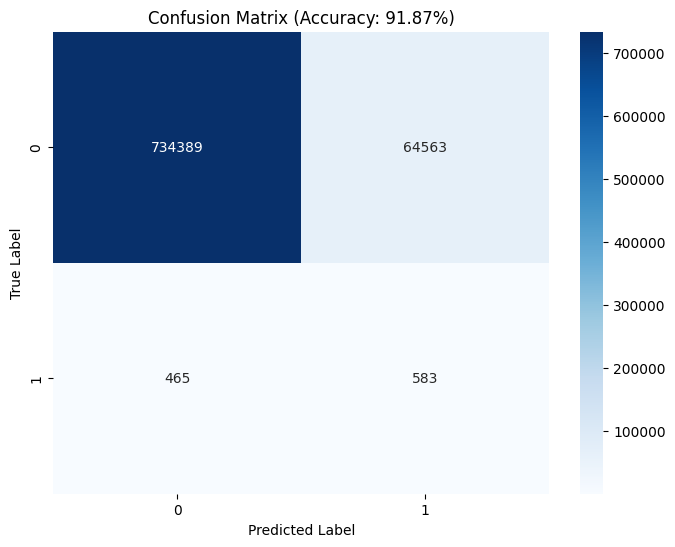


Additional Metrics:
Total transactions analyzed: 800000
Fraud cases detected: 583
False positive cases: 64563
False positive rate: 8.07%
Model accuracy: 91.87%

Model saved successfully at: models\fraud_detector_acc91.87_20241104_182845.pkl
Model metadata:
- creation_date: 2024-11-04 18:28:45.231410
- last_training_date: 2024-11-04 18:28:45.231410
- accuracy_score: 0.918715
- number_of_rules: 6

Rules triggered: []


In [20]:
# Load your dataset
df = pd.read_csv('modeling_data.csv')

# Initialize the detector
detector = RuleBasedFraudDetector()

# Train and evaluate the model
detector.train_and_evaluate(df, df['isFraud'])

# Save the model
detector.save_model()

# For a specific transaction, get explanation
explanations = detector.explain_prediction(df.iloc[0])
print(f"\nRules triggered: {explanations}")

In [23]:
loaded_model = RuleBasedFraudDetector.load_model('models\\fraud_detector_acc91.87_20241104_182845.pkl')


Model loaded successfully from: models\fraud_detector_acc91.87_20241104_182845.pkl
Model metadata:
- creation_date: 2024-11-04 18:28:45.231410
- last_training_date: 2024-11-04 18:28:45.231410
- accuracy_score: 0.918715
- number_of_rules: 6
